# Industrial polymerization reactor

In this Jupyter Notebook we illustrate the concept of approximate model predictive control on the more complex nonlinear example of the **industrial poly reactor**.
We will use this to introduce the usage of approximate MPC in do-mpc, which is quite similiar to the do-it-yourself MPC but way easier to use than building everything from scratch.

In the following the different parts are presented. But first, we start by importing basic modules and **do-mpc**.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from casadi import *
from do_mpc.tools import Timer
import jdc
# Add do_mpc to path. This is not necessary if it was installed via pip
import os
import torch
rel_do_mpc_path = os.path.join('..','..','..')
sys.path.append(rel_do_mpc_path)

# Import do_mpc package:
import do_mpc

## Model

In the following we will present the `model` of the polyreactor.
The considered model of the industrial reactor is continuous and has 10 states and 3 control inputs.
The model is initiated by:

In [55]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

### System description

The system consists of a reactor into which nonomer is fed.
The monomerturns into a polymer via a very exothermic chemical reaction.
The reactor is equipped with a jacket and with an External Heat Exchanger(EHE) that can both be used to control the temperature inside the reactor.
A schematic representation of the system is presented below:

![polysketch](industiral_poly_sketch.svg "Industrial polymerization batch reactor")

The process is modeled by a set of 8 ordinary differential equations (ODEs):

\begin{align}
\dot{m}_{\text{W}} &=  \ \dot{m}_{\text{F}}\, \omega_{\text{W,F}} \\
\dot{m}_{\text{A}} &=  \ \dot{m}_{\text{F}} \omega_{\text{A,F}}-k_{\text{R1}}\, m_{\text{A,R}}-k_{\text{R2}}\, m_{\text{AWT}}\, m_{\text{A}}/m_{\text{ges}} , \\
\dot{m}_{\text{P}} &=  \ k_{\text{R1}} \, m_{\text{A,R}}+p_{1}\, k_{\text{R2}}\, m_{\text{AWT}}\, m_{\text{A}}/ m_{\text{ges}}, \\
\dot{T}_{\text{R}} &=  \ 1/(c_{\text{p,R}} m_{\text{ges}})\; [\dot{m}_{\text{F}} \; c_{\text{p,F}}\left(T_{\text{F}}-T_{\text{R}}\right) +\Delta H_{\text{R}} k_{\text{R1}} m_{\text{A,R}}-k_{\text{K}} A\left(T_{\text{R}}-T_{\text{S}}\right) \\
&- \dot{m}_{\text{AWT}} \,c_{\text{p,R}}\left(T_{\text{R}}-T_{\text{EK}}\right)],\notag\\
\dot{T}_{S} &=  1/(c_{\text{p,S}} m_{\text{S}}) \;[k_{\text{K}} A\left(T_{\text{R}}-T_{\text{S}}\right)-k_{\text{K}} A\left(T_{\text{S}}-T_{\text{M}}\right)], \notag\\
\dot{T}_{\text{M}} &=  1/(c_{\text{p,W}} m_{\text{M,KW}})\;[\dot{m}_{\text{M,KW}}\, c_{\text{p,W}}\left(T_{\text{M}}^{\text{IN}}-T_{\text{M}}\right) \\
&+ k_{\text{K}} A\left(T_{\text{S}}-T_{\text{M}}\right)]+k_{\text{K}} A\left(T_{\text{S}}-T_{\text{M}}\right)], \\
\dot{T}_{\text{EK}}&=  1/(c_{\text{p,R}} m_{\text{AWT}})\;[\dot{m}_{\text{AWT}} c_{\text{p,W}}\left(T_{\text{R}}-T_{\text{EK}}\right)-\alpha\left(T_{\text{EK}}-T_{\text{AWT}}\right)  \\ 
&+   k_{\text{R2}}\, m_{\text{A}}\, m_{\text{AWT}}\Delta H_{\text{R}}/m_{\text{ges}}], \notag\\
\dot{T}_{\text{AWT}} &=  [\dot{m}_{\text{AWT,KW}} \,c_{\text{p,W}}\,(T_{\text{AWT}}^{\text{IN}}-T_{\text{AWT}})-\alpha\left(T_{\text{AWT}}-T_{\text{EK}}\right)]/(c_{\text{p,W}} m_{\text{AWT,KW}}),
\end{align}

where

\begin{align}
U       &=  m_{\text{P}}/(m_{\text{A}}+m_{\text{P}}), \\
m_{\text{ges}} &=  \  m_{\text{W}}+m_{\text{A}}+m_{\text{P}}, \\
k_{\text{R1}}  &=  \  k_{0} e^{\frac{-E_{a}}{R (T_{\text{R}}+273.15)}}\left(k_{\text{U1}}\left(1-U\right)+k_{\text{U2}} U\right), \\
k_{\text{R2}}  &=  \  k_{0} e^{\frac{-E_{a}}{R (T_{\text{EK}}+273.15)}}\left(k_{\text{U1}}\left(1-U\right)+k_{\text{U2}} U\right), \\
k_{\text{K}}   &=  (m_{\text{W}}k_{\text{WS}}+m_{\text{A}}k_{\text{AS}}+m_{\text{P}}k_{\text{PS}})/m_{\text{ges}},\\
m_{\text{A,R}} &=  m_\text{A}-m_\text{A} m_{\text{AWT}}/m_{\text{ges}}.
\end{align}

The model includes mass balances for the water, monomer and product hold-ups ($m_\text{W}$, $m_\text{A}$, $m_\text{P}$) and energy balances for the reactor ($T_\text{R}$), the vessel ($T_\text{S}$), the jacket ($T_\text{M}$), the mixture in the external heat exchanger ($T_{\text{EK}}$) and the coolant leaving the external heat exchanger ($T_{\text{AWT}}$).
The variable $U$ denotes the polymer-monomer ratio  in the reactor, $m_{\text{ges}}$ represents the total mass, $k_{\text{R1}}$ is the reaction rate inside the reactor and $k_{\text{R2}}$ is the reaction rate in the external heat exchanger. The total heat transfer coefficient of the mixture inside the reactor is denoted as $k_{\text{K}}$ and $m_{\text{A,R}}$ represents the current amount of monomer inside the reactor.

The available control inputs are the feed flow $\dot{m}_{\text{F}}$, the coolant temperature at the inlet of the jacket $T^{\text{IN}}_{\text{M}}$ and the coolant temperature at the inlet of the external heat exchanger $T^{\text{IN}}_{\text{AWT}}$.

An overview of the parameters are listed below:

![polyparameters](poly_reactor_parameters.png "Parameters of the polymerization reactor")

### Implementation

First, we set the certain parameters:

In [56]:
# Certain parameters
R           = 8.314			#gas constant
T_F         = 25 + 273.15	#feed temperature
E_a         = 8500.0		#activation energy
delH_R      = 950.0*1.00	#sp reaction enthalpy
A_tank      = 65.0			#area heat exchanger surface jacket 65

k_0         = 7.0*1.00		#sp reaction rate
k_U2        = 32.0			#reaction parameter 1
k_U1        = 4.0			#reaction parameter 2
w_WF        = .333			#mass fraction water in feed
w_AF        = .667			#mass fraction of A in feed

delH_R = 950
k_0 =    7

m_M_KW      = 5000.0		#mass of coolant in jacket
fm_M_KW     = 300000.0		#coolant flow in jacket 300000;
m_AWT_KW    = 1000.0		#mass of coolant in EHE
fm_AWT_KW   = 100000.0		#coolant flow in EHE
m_AWT       = 200.0			#mass of product in EHE
fm_AWT      = 20000.0		#product flow in EHE
m_S         = 39000.0		#mass of reactor steel

c_pW        = 4.2			#sp heat cap coolant
c_pS        = .47			#sp heat cap steel
c_pF        = 3.0			#sp heat cap feed
c_pR        = 5.0			#sp heat cap reactor contents

k_WS        = 17280.0		#heat transfer coeff water-steel
k_AS        = 3600.0		#heat transfer coeff monomer-steel
k_PS        = 360.0			#heat transfer coeff product-steel

alfa        = 5*20e4*3.6

p_1         = 1.0

The 10 states of the control problem stem from the 8 ODEs, `accum_monom`  models the amount that has been fed to the reactor via $\dot{m}_\text{F}^{\text{acc}} = \dot{m}_{\text{F}}$ and `T_adiab` ($T_{\text{adiab}}=\frac{\Delta H_{\text{R}}}{c_{\text{p,R}}} \frac{m_{\text{A}}}{m_{\text{ges}}} + T_{\text{R}}$, hence $\dot{T}_{\text{adiab}}=\frac{\Delta H_{\text{R}}}{m_{\text{ges}} c_{\text{p,R}}}\dot{m}_{\text{A}}-
\left(\dot{m}_{\text{W}}+\dot{m}_{\text{A}}+\dot{m}_{\text{P}}\right)\left(\frac{m_{\text{A}} \Delta H_{\text{R}}}{m_{\text{ges}}^2c_{\text{p,R}}}\right)+\dot{T}_{\text{R}}$) is a virtual variable that is important for safety aspects, as we will explain later.
All states are created in **do-mpc** via:

In [57]:
# States struct (optimization variables):
m_W =         model.set_variable('_x', 'm_W')
m_A =         model.set_variable('_x', 'm_A')
m_P =         model.set_variable('_x', 'm_P')
T_R =         model.set_variable('_x', 'T_R')
T_S =         model.set_variable('_x', 'T_S')
Tout_M =      model.set_variable('_x', 'Tout_M')
T_EK =        model.set_variable('_x', 'T_EK')
Tout_AWT =    model.set_variable('_x', 'Tout_AWT')
accum_monom = model.set_variable('_x', 'accum_monom')
T_adiab =     model.set_variable('_x', 'T_adiab')

and the control inputs via:

In [58]:
# Input struct (optimization variables):
m_dot_f = model.set_variable('_u', 'm_dot_f')
T_in_M =  model.set_variable('_u', 'T_in_M')
T_in_EK = model.set_variable('_u', 'T_in_EK')

Before defining the ODE for each state variable, we create auxiliary terms:

In [59]:
# algebraic equations
U_m    = m_P / (m_A + m_P)
m_ges  = m_W + m_A + m_P
k_R1   = k_0 * exp(- E_a/(R*T_R)) * ((k_U1 * (1 - U_m)) + (k_U2 * U_m))
k_R2   = k_0 * exp(- E_a/(R*T_EK))* ((k_U1 * (1 - U_m)) + (k_U2 * U_m))
k_K    = ((m_W / m_ges) * k_WS) + ((m_A/m_ges) * k_AS) + ((m_P/m_ges) * k_PS)

The auxiliary terms are used for the more readable definition of the ODEs:

In [60]:
# Differential equations
dot_m_W = m_dot_f * w_WF
model.set_rhs('m_W', dot_m_W)
dot_m_A = (m_dot_f * w_AF) - (k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))) - (p_1 * k_R2 * (m_A/m_ges) * m_AWT)
model.set_rhs('m_A', dot_m_A)
dot_m_P = (k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))) + (p_1 * k_R2 * (m_A/m_ges) * m_AWT)
model.set_rhs('m_P', dot_m_P)

dot_T_R = 1./(c_pR * m_ges)   * ((m_dot_f * c_pF * (T_F - T_R)) - (k_K *A_tank* (T_R - T_S)) - (fm_AWT * c_pR * (T_R - T_EK)) + (delH_R * k_R1 * (m_A-((m_A*m_AWT)/(m_W+m_A+m_P)))))
model.set_rhs('T_R', dot_T_R)
model.set_rhs('T_S', 1./(c_pS * m_S)     * ((k_K *A_tank* (T_R - T_S)) - (k_K *A_tank* (T_S - Tout_M))))
model.set_rhs('Tout_M', 1./(c_pW * m_M_KW)  * ((fm_M_KW * c_pW * (T_in_M - Tout_M)) + (k_K *A_tank* (T_S - Tout_M))))
model.set_rhs('T_EK', 1./(c_pR * m_AWT)   * ((fm_AWT * c_pR * (T_R - T_EK)) - (alfa * (T_EK - Tout_AWT)) + (p_1 * k_R2 * (m_A/m_ges) * m_AWT * delH_R)))
model.set_rhs('Tout_AWT', 1./(c_pW * m_AWT_KW)* ((fm_AWT_KW * c_pW * (T_in_EK - Tout_AWT)) - (alfa * (Tout_AWT - T_EK))))
model.set_rhs('accum_monom', m_dot_f)
model.set_rhs('T_adiab', delH_R/(m_ges*c_pR)*dot_m_A-(dot_m_A+dot_m_W+dot_m_P)*(m_A*delH_R/(m_ges*m_ges*c_pR))+dot_T_R)

Finally, the model setup is completed:

In [61]:
# Build the model
model.setup()

## Controller


Next, the model predictive controller is configured.
First, one member of the mpc class is generated with the prediction model defined above:

In [64]:
mpc = do_mpc.controller.MPC(model)

Real processes are also subject to important safety constraints that are incorporated to account for possible failures of the equipment. In this case, the maximum temperature that the reactor would reach in the case of a cooling failure is constrained to be below $109 ^\circ$C.
The temperature that the reactor would achieve in the case of a complete cooling failure is $T_{\text{adiab}}$, hence it needs to stay beneath $109 ^\circ$C.

We choose the prediction horizon `n_horizon`, set the robust horizon `n_robust` to 0. The time step `t_step` is set to one second and parameters of the applied discretization scheme orthogonal collocation are as seen below:

In [65]:
setup_mpc = {
    'n_horizon': 20,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 50.0/3600.0,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    #'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

### Objective

The goal of the economic NMPC controller is to produce $20680~\text{kg}$ of $m_{\text{P}}$ as fast as possible.
Additionally, we add a penalty on input changes for all three control inputs, to obtain a smooth control performance.

In [66]:
_x = model.x
mterm = - _x['m_P'] # terminal cost
lterm = - _x['m_P'] # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(m_dot_f=0.002, T_in_M=0.004, T_in_EK=0.002) # penalty on control input changes

### Constraints

The temperature at which the polymerization reaction takes place strongly influences the properties of the resulting polymer. For this reason, the temperature of the reactor should be maintained in a range of $\pm 2.0  ^\circ$C around the desired reaction temperature $T_{\text{set}}=90 ^\circ$C in order to ensure that the produced polymer has the required properties.  

The initial conditions and the bounds for all states are summarized in:

![polybounds](industrial_poly_states.png "States and their initial conditions and bounds")

and set via:

In [67]:
# auxiliary term
temp_range = 2.0
mpc.settings.supress_ipopt_output()
# lower bound states
mpc.bounds['lower','_x','m_W'] = 0.0
mpc.bounds['lower','_x','m_A'] = 0.0
mpc.bounds['lower','_x','m_P'] = 26.0

mpc.bounds['lower','_x','T_R'] = 363.15 - temp_range
mpc.bounds['lower','_x','T_S'] = 298.0
mpc.bounds['lower','_x','Tout_M'] = 298.0
mpc.bounds['lower','_x','T_EK'] = 288.0
mpc.bounds['lower','_x','Tout_AWT'] = 288.0
mpc.bounds['lower','_x','accum_monom'] = 0.0


mpc.bounds['upper','_x','T_S'] = 400.0
mpc.bounds['upper','_x','Tout_M'] = 400.0
mpc.bounds['upper','_x','T_EK'] = 400.0
mpc.bounds['upper','_x','Tout_AWT'] = 400.0
mpc.bounds['upper','_x','accum_monom'] = 30000.0
mpc.bounds['upper','_x','T_adiab'] = 382.15

The upper bound of the reactor temperature is set via a soft-constraint:

In [68]:
mpc.set_nl_cons('T_R_UB', _x['T_R'], ub=363.15+temp_range, soft_constraint=True, penalty_term_cons=1e4)

SX(T_R)

The bounds of the inputsare summarized below:

![polyinputbounds](industrial_poly_inputs.png "Control inputs and their bounds")

and set via:

In [69]:
# lower bound inputs
mpc.bounds['lower','_u','m_dot_f'] = 0.0
mpc.bounds['lower','_u','T_in_M'] = 333.15
mpc.bounds['lower','_u','T_in_EK'] = 333.15

# upper bound inputs
mpc.bounds['upper','_u','m_dot_f'] = 3.0e4
mpc.bounds['upper','_u','T_in_M'] = 373.15
mpc.bounds['upper','_u','T_in_EK'] = 373.15

### Scaling

Because the magnitudes of the states and inputs are very different, the performance of the optimizer can be enhanced by properly scaling the states and inputs:

In [70]:
# states
mpc.scaling['_x','m_W'] = 10
mpc.scaling['_x','m_A'] = 10
mpc.scaling['_x','m_P'] = 10
mpc.scaling['_x','accum_monom'] = 10

# control inputs
mpc.scaling['_u','m_dot_f'] = 100

The setup of the MPC controller is concluded by:

In [71]:
mpc.setup()

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [72]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [73]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the same time step `t_step` as for the optimizer:

In [79]:
params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 50.0/3600.0
}

simulator.set_param(**params_simulator)
simulator.setup()

## Closed-loop simulation

For the simulation of the MPC configured for the polyreactor, we define the initial state of the system and set it for all parts of the closed-loop configuration:

In [80]:
# Set the initial state of the controller and simulator:
# assume nominal values of uncertain parameters as initial guess
delH_R_real = 950.0
c_pR = 5.0

# x0 is a property of the simulator - we obtain it and set values.
x0 = simulator.x0

x0['m_W'] = 10000.0
x0['m_A'] = 853.0
x0['m_P'] = 26.5

x0['T_R'] = 90.0 + 273.15
x0['T_S'] = 90.0 + 273.15
x0['Tout_M'] = 90.0 + 273.15
x0['T_EK'] = 35.0 + 273.15
x0['Tout_AWT'] = 35.0 + 273.15
x0['accum_monom'] = 300.0
x0['T_adiab'] = x0['m_A']*delH_R_real/((x0['m_W'] + x0['m_A'] + x0['m_P']) * c_pR) + x0['T_R']
print(x0['T_adiab'])
mpc.reset_history()
simulator.reset_history()
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0
timer = Timer()
mpc.set_initial_guess()

378.047


Now, we simulate the closed-loop for 100 steps (and suppress the output of the cell with the magic command `%%capture`):

In [81]:
for k in range(100):
    timer.tic()
    u0 = mpc.make_step(x0)
    timer.toc()
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
    if x0[8]>29900:
        break

In [82]:
print("Time step goal reached: "+str(k))
timer.info()

Time step goal reached: 96
Average runtime 281.44329896907215+-93.64155931184568ms. Fastest run 205.0ms, slowest run 1057.0ms.


## Animating the results

To animate the results, we first configure the **do-mpc** graphics object, which is initiated with the respective data object:

In [83]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

We quickly configure Matplotlib.

In [84]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

We then create a figure, configure which lines to plot on which axis and add labels.

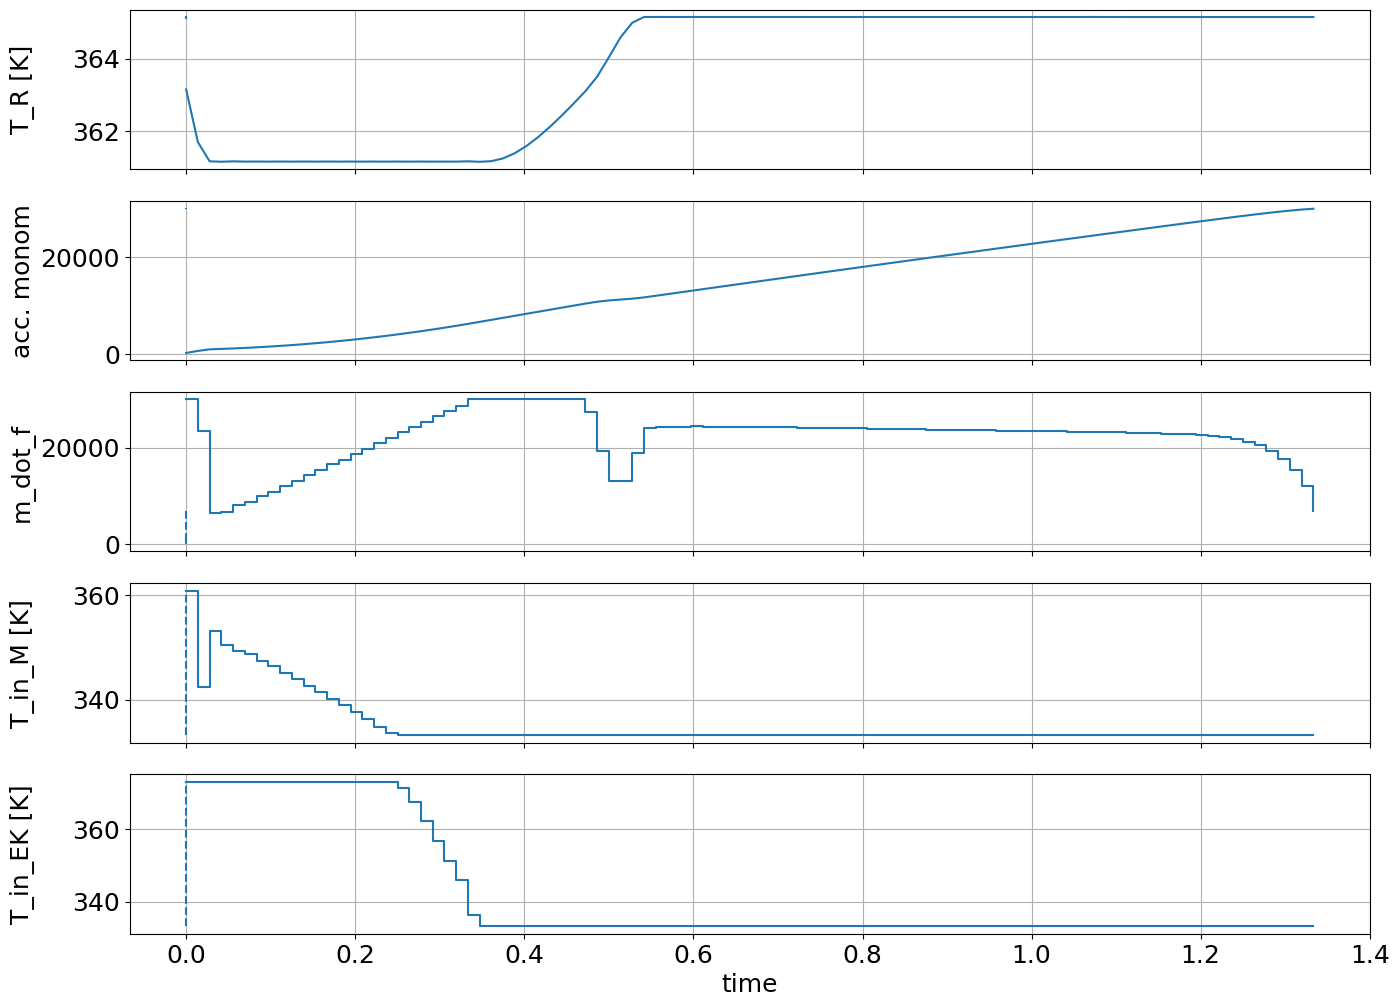

In [85]:
fig, ax = plt.subplots(5, sharex=True, figsize=(16,12))
plt.ion()
# Configure plot:
mpc_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[0])
mpc_graphics.add_line(var_type='_x', var_name='accum_monom', axis=ax[1])
mpc_graphics.add_line(var_type='_u', var_name='m_dot_f', axis=ax[2])
mpc_graphics.add_line(var_type='_u', var_name='T_in_M', axis=ax[3])
mpc_graphics.add_line(var_type='_u', var_name='T_in_EK', axis=ax[4])

ax[0].set_ylabel('T_R [K]')
ax[1].set_ylabel('acc. monom')
ax[2].set_ylabel('m_dot_f')
ax[3].set_ylabel('T_in_M [K]')
ax[4].set_ylabel('T_in_EK [K]')
ax[4].set_xlabel('time')

fig.align_ylabels()
mpc_graphics.plot_results()

## Approximate MPC definition
First we again need to define the neural network that serves as our approximate MPC model. The class 'do_mpc.approximate_mpc.ApproximateMPC' is used to create the neural network. We will first do it with open-loop sampling to show its downside in large sampling spaces, and follow up with a closed-loop ampling.

In [87]:
approx_mpc = do_mpc.approximateMPC.ApproxMPC(mpc)

All parameters of this class as well as all other classed in do-mpc comes with pre-defined settings, that can be overwritten e.g. the number of layers or neurons of the network.


In [88]:
approx_mpc.settings.n_hidden_layers = 3
approx_mpc.settings.n_neurons = 50
approx_mpc.settings.lbx[-1]=0
approx_mpc.settings.ubx[0,0:4]=torch.tensor([[30000],[25000],[2500],[363.15+2.5]]).T

Once all parameters are set, we finish the configuration of the approximate MPC by calling:

In [89]:
approx_mpc.setup()

----------------------------------
ApproxMPC(
  (net): FeedforwardNN(
    (layers): ModuleList(
      (0): Linear(in_features=13, out_features=50, bias=True)
      (1): ReLU()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): ReLU()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): ReLU()
      (6): Linear(in_features=50, out_features=3, bias=True)
    )
  )
)
----------------------------------


C:\Users\smjsadam\Documents\Job\Forschung\2025-workshop-dycops\lib\site-packages\torch\utils\_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


## Sampling
To sample the data for training of the neural network we established a sampler class that used the already defined do-mpc sampling planner to generate data. This smapler samples within the bounds of the states and inputs defined in the do-mpc model. Again, we can overwrite the default settings such as the number of samples

In [91]:
sampler = do_mpc.approximateMPC.Sampler(mpc)
#sampler.settings.trajectory_length = 100
n_samples = 10000
sampler.settings.n_samples = n_samples

sampler.settings.lbx[-1] =0
sampler.settings.ubx[0:4] = np.array([[30000],[25000],[2500],[363.15+2.5]])

We will use the default open-loop sampling.

In [92]:
sampler.setup()

Future releases will allow for self-defined sampling functions. In the end, the sampling consists of generating a sampling plan within the sampling bounds and then executing the closed-loop simulation while solving the MPC problem un each time step. This is merged into one default sampling function, which we don't want to wait for all to finish let us skip the sampling


In [93]:
#sampler.default_sampling()


## Training
After sampling the data, we train the neural network on said dataset. This training is done with the Trainer class, which defines the duration of the training and other hyperparameters such as the learning rate. These variables, that also includes the direction where the data is stored and where the results will be stored. If those remain in the dedfault setting the user does not have to deal with it. We set the hyperparameters for the training and finish by calling the setup function

In [94]:
trainer = do_mpc.approximateMPC.Trainer(approx_mpc)
trainer.settings.n_samples = n_samples
trainer.settings.n_epochs = 5000
trainer.settings.scheduler_flag=True
trainer.settings.show_fig =True
trainer.settings.save_fig = True
trainer.settings.save_history = False
trainer.setup()

Again, the training is initiated with one simple function

Path from trainer to sampled files
 sampling\data_n10000_opt.pkl
epoch :  9
train_loss :  0.0377784688025713
val_loss :  0.043266536667943
-------------------------------
epoch :  19
train_loss :  0.028467772994190454
val_loss :  0.03309140168130398
-------------------------------
epoch :  29
train_loss :  0.023282159119844437
val_loss :  0.03228294476866722
-------------------------------
epoch :  39
train_loss :  0.021044576657004654
val_loss :  0.027905303984880447
-------------------------------
epoch :  49
train_loss :  0.021725258324295282
val_loss :  0.03153757471591234
-------------------------------
epoch :  59
train_loss :  0.017789628822356462
val_loss :  0.02256129588931799
-------------------------------
epoch :  69
train_loss :  0.01726300618611276
val_loss :  0.022287569008767605
-------------------------------
epoch :  79
train_loss :  0.017316527664661407
val_loss :  0.022109227254986763
-------------------------------
epoch :  89
train_loss :  0.016666911891661584
val

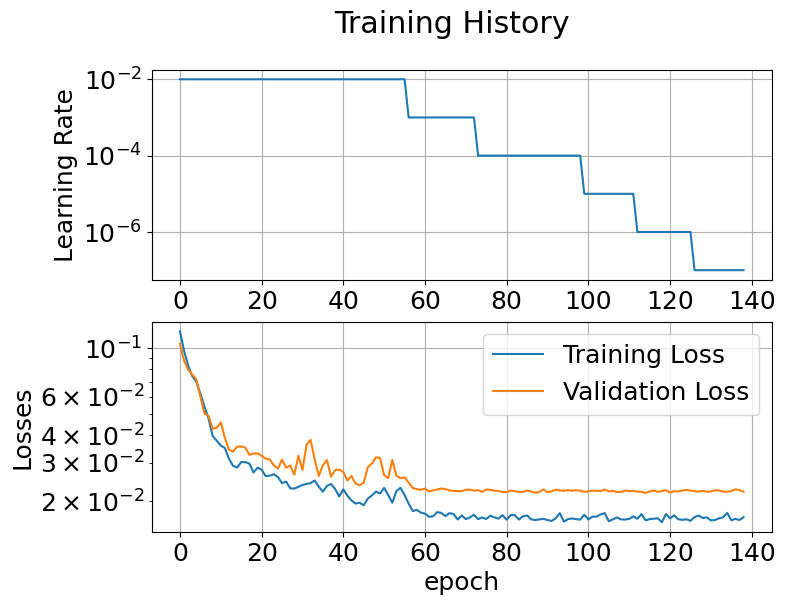

In [51]:
trainer.default_training()

## Simulation
Finally, we can simulate the approx_mpc in the closed-loop application, similary to evaluating a mpc controller. The main difference is of-course that we only evaluate a neural network instead of solving a optimization problem.

In [52]:
# Set the initial state of the controller and simulator:
# assume nominal values of uncertain parameters as initial guess
delH_R_real = 950.0
c_pR = 5.0

# x0 is a property of the simulator - we obtain it and set values.
x0 = simulator.x0

x0['m_W'] = 10000.0
x0['m_A'] = 853.0
x0['m_P'] = 26.5

x0['T_R'] = 90.0 + 273.15
x0['T_S'] = 90.0 + 273.15
x0['Tout_M'] = 90.0 + 273.15
x0['T_EK'] = 35.0 + 273.15
x0['Tout_AWT'] = 35.0 + 273.15
x0['accum_monom'] = 300.0
x0['T_adiab'] = x0['m_A']*delH_R_real/((x0['m_W'] + x0['m_A'] + x0['m_P']) * c_pR) + x0['T_R']
print(x0['T_adiab'])
mpc.reset_history()
simulator.reset_history()
x0=x0.cat.full()
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0
timer = Timer()
sim_time = 100
#approx_mpc.u0=u0

for k in range(sim_time):
    timer.tic()
    u0 = approx_mpc.make_step(x0,clip_to_bounds=True)
    timer.toc()
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
    if x0[8]>200:
        break
print(k)
print(x0[8])
timer.info()

378.047
99
[21648.4213377]
Average runtime 0.22+-0.41424630354415964ms. Fastest run 0.0ms, slowest run 1.0ms.


## Visualization
Let us finally plot the result of this closed-loop application by using the simulator data from do-mpc:

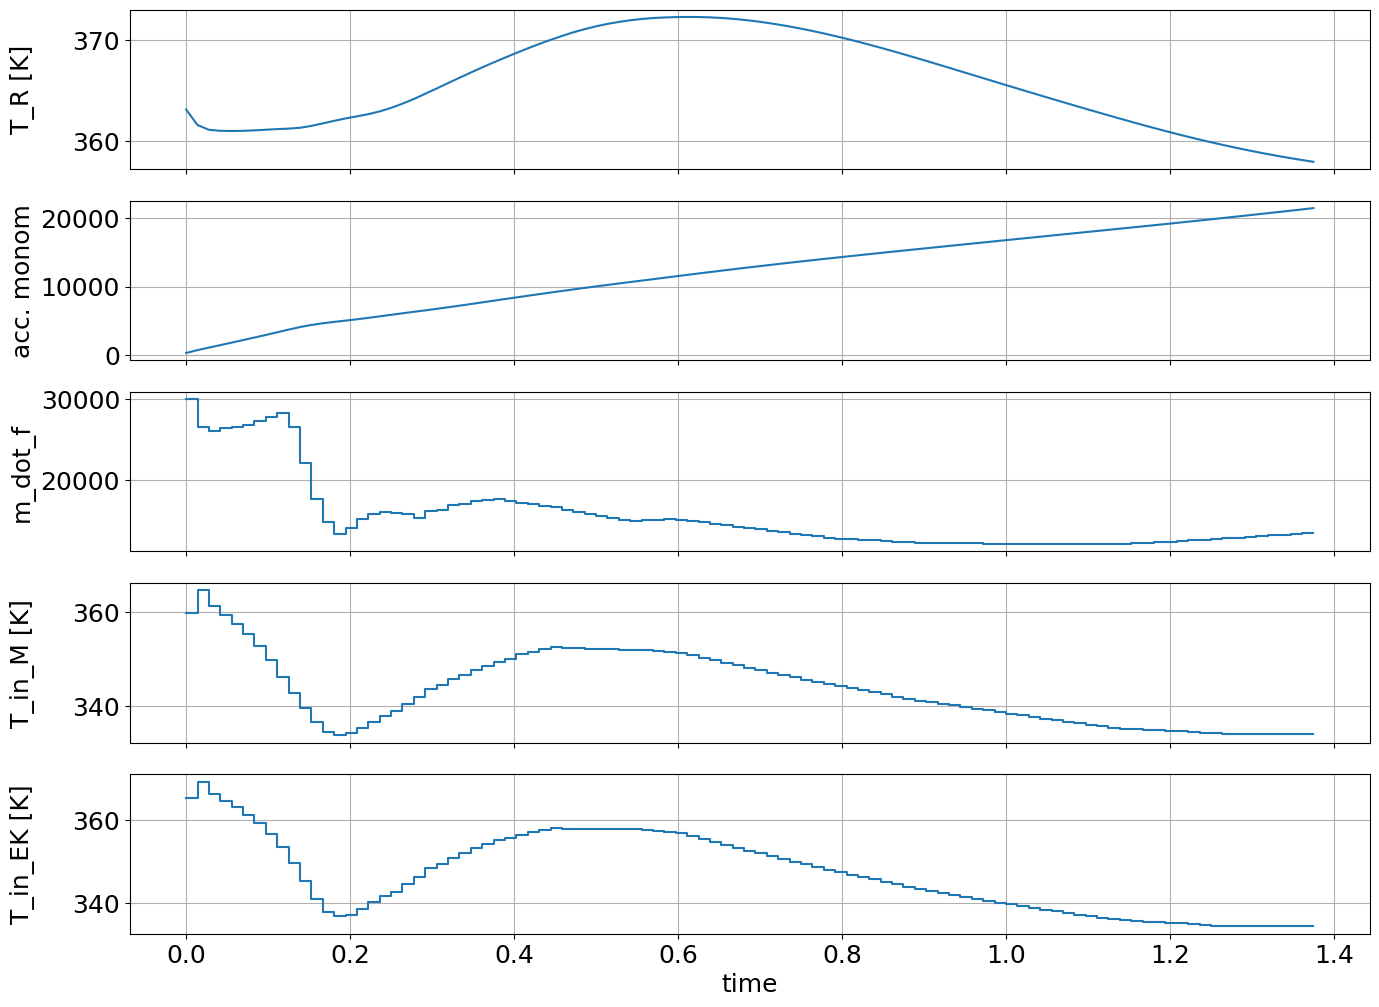

In [53]:
mpc_graphics = do_mpc.graphics.Graphics(simulator.data)

fig, ax = plt.subplots(5, sharex=True, figsize=(16,12))
plt.ion()
# Configure plot:
mpc_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[0])
mpc_graphics.add_line(var_type='_x', var_name='accum_monom', axis=ax[1])
mpc_graphics.add_line(var_type='_u', var_name='m_dot_f', axis=ax[2])
mpc_graphics.add_line(var_type='_u', var_name='T_in_M', axis=ax[3])
mpc_graphics.add_line(var_type='_u', var_name='T_in_EK', axis=ax[4])

ax[0].set_ylabel('T_R [K]')
ax[1].set_ylabel('acc. monom')
ax[2].set_ylabel('m_dot_f')
ax[3].set_ylabel('T_in_M [K]')
ax[4].set_ylabel('T_in_EK [K]')
ax[4].set_xlabel('time')

fig.align_ylabels()
mpc_graphics.plot_results()

# Closed-loop sampling

We will do the same steps again this time setting a closed-loop sampling in place, where we only start in an region of interest and sample entire batch trajectories

## Approximate MPC definition
First we again need to define the neural network that serves as our approximate MPC model. The class 'do_mpc.approximate_mpc.ApproximateMPC' is used to create the neural network.

In [55]:
approx_mpc = do_mpc.approximateMPC.ApproxMPC(mpc)
approx_mpc.settings.n_hidden_layers = 3
approx_mpc.settings.n_neurons = 50
approx_mpc.settings.lbx[-1]=0
approx_mpc.settings.ubx[0,0:4]=torch.tensor([[30000],[25000],[2500],[363.15+2.5]]).T
approx_mpc.setup()

## Sampling
All we have to change in the sampling is to setup a closed-loop sampling via the settings and set a different set of starting values.

In [32]:
sampler = do_mpc.approximateMPC.Sampler(mpc)
sampler.settings.trajectory_length = 100
n_samples = 100
sampler.settings.n_samples = n_samples
lbx=np.array([10000.0-2000,853.0-53,26.5-1.5,90.0-10 + 273.15,90.0-10 + 273.15,90.0-10 + 273.15,35.0-10 + 273.15,35.0-10 + 273.15,300.0-200,375])
ubx=np.array([10000.0+2000,853.0+47,26.5+1.5,90.0+10 + 273.15,90.0+10 + 273.15,90.0+10 + 273.15,35.0+10 + 273.15,35.0+10 + 273.15,300.0+200,380])
sampler.settings.lbx = lbx
sampler.settings.ubx = ubx
sampler.settings.closed_loop_flag = True
sampler.setup()

Again we don't really call the default_sampling function right now as it will some time. I have done it before, the data is stored is the default sampling direction and will be found by the trainer


In [34]:
#sampler.default_sampling()


Progress: |██████████████████████████████████████████████████| 100.0% Complete


## Training
The trainer is defined similary as before

In [58]:
trainer = do_mpc.approximateMPC.Trainer(approx_mpc)
trainer.settings.n_samples = n_samples
trainer.settings.n_epochs = 5000
trainer.settings.scheduler_flag=True
trainer.settings.show_fig =True
trainer.settings.save_fig = True
trainer.settings.save_history = False
trainer.setup()

Again, the training is initiated with one simple function

Path from trainer to sampled files
 sampling\data_n100_opt.pkl
epoch :  9
train_loss :  0.010798276588320731
val_loss :  0.01126388181000948
-------------------------------
epoch :  19
train_loss :  0.006769729126244783
val_loss :  0.008201681077480316
-------------------------------
epoch :  29
train_loss :  0.005266560707241297
val_loss :  0.006376314675435424
-------------------------------
epoch :  39
train_loss :  0.004922125022858381
val_loss :  0.00827697478234768
-------------------------------
epoch :  49
train_loss :  0.00505996560677886
val_loss :  0.005390744656324387
-------------------------------
epoch :  59
train_loss :  0.004353695688769222
val_loss :  0.004330409807153046
-------------------------------
epoch :  69
train_loss :  0.00433779377490282
val_loss :  0.004314103745855391
-------------------------------
epoch :  79
train_loss :  0.004417131608352065
val_loss :  0.007161452900618315
-------------------------------
epoch :  89
train_loss :  0.004540793551132083

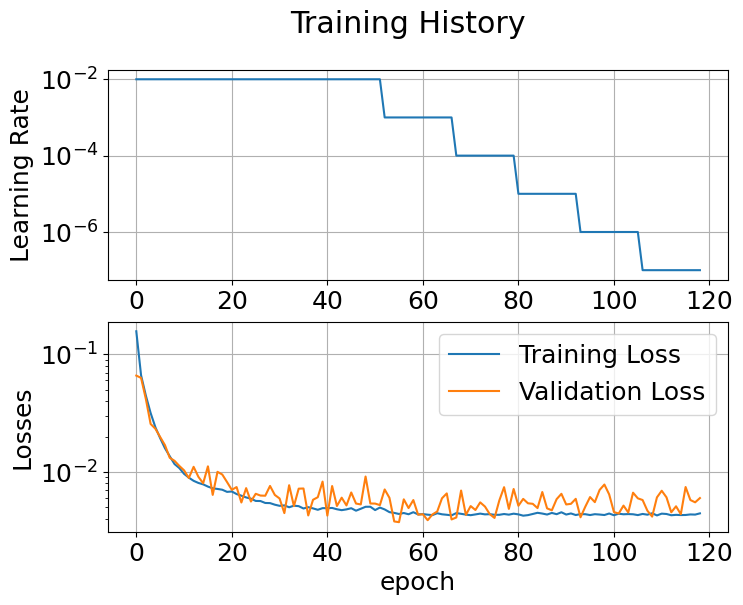

In [59]:
trainer.default_training()

## Simulation
Finally, we can simulate the approx_mpc in the closed-loop application, similary to evaluating a mpc controller. The main difference is of-course that we only evaluate a neural network instead of solving a optimization problem.

In [60]:
# Set the initial state of the controller and simulator:
# assume nominal values of uncertain parameters as initial guess
delH_R_real = 950.0
c_pR = 5.0

# x0 is a property of the simulator - we obtain it and set values.
x0 = simulator.x0

x0['m_W'] = 10000.0
x0['m_A'] = 853.0
x0['m_P'] = 26.5

x0['T_R'] = 90.0 + 273.15
x0['T_S'] = 90.0 + 273.15
x0['Tout_M'] = 90.0 + 273.15
x0['T_EK'] = 35.0 + 273.15
x0['Tout_AWT'] = 35.0 + 273.15
x0['accum_monom'] = 300.0
x0['T_adiab'] = x0['m_A']*delH_R_real/((x0['m_W'] + x0['m_A'] + x0['m_P']) * c_pR) + x0['T_R']
print(x0['T_adiab'])
mpc.reset_history()
simulator.reset_history()
x0=x0.cat.full()
mpc.x0 = x0
simulator.x0 = x0
estimator.x0 = x0
timer = Timer()
sim_time = 100
#approx_mpc.u0=u0

for k in range(sim_time):
    timer.tic()
    u0 = approx_mpc.make_step(x0,clip_to_bounds=True)
    timer.toc()
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
    if x0[8]>29900:
        break
print(k)
print(x0[8])
timer.info()

378.047
97
[29963.62918417]
Average runtime 0.20408163265306123+-0.40302893179860205ms. Fastest run 0.0ms, slowest run 1.0ms.


## Visualization
Let us finally plot the result of this closed-loop application by using the simulator data from do-mpc:

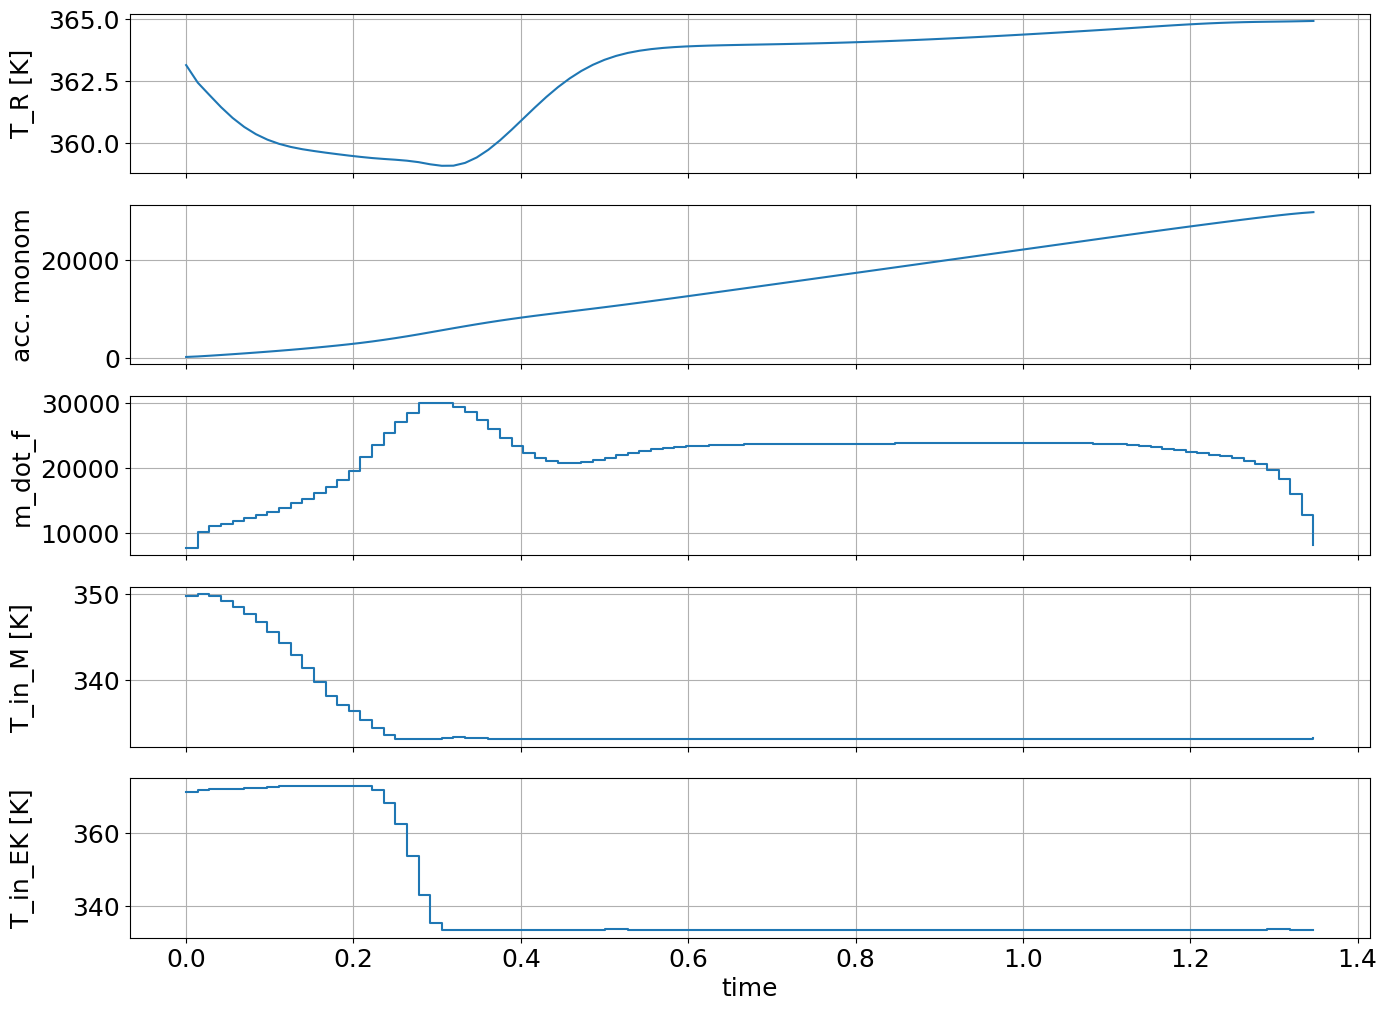

In [61]:
mpc_graphics = do_mpc.graphics.Graphics(simulator.data)

fig, ax = plt.subplots(5, sharex=True, figsize=(16,12))
plt.ion()
# Configure plot:
mpc_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[0])
mpc_graphics.add_line(var_type='_x', var_name='accum_monom', axis=ax[1])
mpc_graphics.add_line(var_type='_u', var_name='m_dot_f', axis=ax[2])
mpc_graphics.add_line(var_type='_u', var_name='T_in_M', axis=ax[3])
mpc_graphics.add_line(var_type='_u', var_name='T_in_EK', axis=ax[4])

ax[0].set_ylabel('T_R [K]')
ax[1].set_ylabel('acc. monom')
ax[2].set_ylabel('m_dot_f')
ax[3].set_ylabel('T_in_M [K]')
ax[4].set_ylabel('T_in_EK [K]')
ax[4].set_xlabel('time')

fig.align_ylabels()
mpc_graphics.plot_results()